# Prediction of Grocery Store Sales Using Spatial Interaction Modelling (SIM)
<hr>
This project is inspired by the Spatial Modelling for Retail Analytics course offered by the [Consumer Data Research Center (CDRC)](https://www.cdrc.ac.uk/) I recently attended. The course was held by [Dr. Andy Newing](https://environment.leeds.ac.uk/geography/staff/1081/dr-andy-newing) and [Dr. Nick Hood](https://environment.leeds.ac.uk/geography/staff/1051/dr-nick-hood). Andy and Nick did a wanderful job at introducing the class to sophisticated analysis and spatial modelling approaches that can be used to understand retail sector dynamics. Please check out all the CDRC courses and events [here](https://www.cdrc.ac.uk/events/).

The technique that stood out the most to me was **Spatial Interaction Modelling**. This technique is used in social sciences to predict and describe behaviours that mimic gravitation interactions as described by Isaac Newton's law of gravity. 

Three independent conditions are necessary for spatial interaction to occur: 
* Complementarity: There must be supply and demand between the interacting locations. In the specific case of retailing, the supply side are the retail points, while the deman side is the available expenditure of customers. 
* Intervening opportunity (lack of): Refers to a location that may offer a better alternative as a point of origin or as a point of destination. In retail for example, a customer visits a store becasue he/she must not have a closer store that offers similar array of goods. 
* Transferability: Persons being transferred must be supported by transport infrastructures implying that origin and destination must be linked. the cost to overcome distance must not be higher than the benefits of the interaction. 

Spatial interaction models seek to explain spatial flows between **origins** and **destinations**. In this example, the aim is to predict the flow of money into Sheffield grocery stores, given their location, and the available expenditure of the consumers in the modelled area. 

The relationship between money flow, destinations and origins is given by the equation below: 

$$ S_{ij} = A_iO_iW_j exp(-\beta C_{ij}) $$

Where, 

* $S_{ij}$ = flow of expected flow of supermarket $j$ from orgin $i$ 

* $A_i$ = balancing factor that takes into account competition and ensures that demand is allocated to stores within the modelled region. it is calculated as: 

$$ A_i = \frac{1}{\sum W_j exp (-\beta C_{ij})}$$
 
* $W_j$ = represents the overall attractiveness of store j. In this case size is used as a proxy of attractiveness. 
* $exp(-\beta C_{ij})$ = represents the distance deterrence term. $\beta$ is between 0 and 1. $\beta$ = 0 means that the consumer does not mind travelling. $\beta$ = 1 means that the consumer does not want to travel. $C_ij$ represents the distance between origin and supermarket. 






### Important:
This analysis is an adaptation of Dr. Andy Newing's and Dr. Nick Hood's example projects at the CDRC course on Spacial Modelling for Retail Analytics. During the course the computations were made in Excel, I just applied the same models and ideas to a different dataset and modelled the analysis in Python. 



In [946]:
# Import packages

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
from collections import Counter
from math import log, sqrt
import warnings
from mpl_toolkits.basemap import Basemap
from random import randint
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
import scipy as sp

import plotly
import plotly.plotly as py
import plotly.graph_objs as go


warnings.filterwarnings('ignore')
%matplotlib inline

In [947]:
# function to count missing data
def count_missing(data):
    # creates a dataframe containing the sum of all missing values
    missing_count = pd.DataFrame(data.isnull().sum(),\
                                 # names column "Count" and sorts values in descending order
                                 columns=['Count']).sort_values(by=['Count'],\
                                                                ascending=False)
    return missing_count

## The Data
<hr>
The data used for this project was downloaded from [Geolytix](https://geolytix.net/?). The dataset contains over 10,000 UK supermarket roof-top locations size information. Retailers include Aldi, Asda, Booths, Budgens, Co-op, Costco, Lidl, Marks and Spencer, Morrisons, Sainsbury’s, Tesco, Waitrose, Wholefoods.

I then integrated this data with information regarding the origins, or demand zoens. The demand zones are the wards of the city of Sheffield. 
Ward data is available from the [Office for National Statistics](https://www.ons.gov.uk/census/2011census).

In [948]:
# read geolytics data 
data_points = pd.read_csv('./retailpoints.csv')

In [949]:
# copy data and see how dataset looks 
retail_points = data_points
retail_points.head()

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm
0,1010000001,Aldi,Aldi,Aldi Aberdeen,Unit 9-10 Boulevard Retail Park,NaN,Aberdeen,Central Aberdeen,AB11 5EJ,-2.081728,57.148626,395153.8100,806418.6600,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
1,1010000002,Aldi,Aldi,Aldi Westhill,Westhill Drive,NaN,Westhill,NaN,AB32 6FY,-2.278341,57.154810,383260.1400,807138.5400,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
2,1010000003,Aldi,Aldi,Aldi Ellon,Ythan Terrace,NaN,Ellon,NaN,AB41 9LJ,-2.075009,57.363314,395586.8100,830317.9900,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
3,1010000004,Aldi,Aldi,Aldi Inverurie,Loco Works Road,NaN,Inverurie,NaN,AB51 4FY,-2.380156,57.288771,377183.9088,822081.1258,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
4,1010000005,Aldi,Aldi,Aldi Hatfield,11 Parkhouse Court,Comet Way,Hatfield,Hatfield,AL10 9RQ,-0.240950,51.763152,521491.8500,208626.7200,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"


In [950]:
print('The dataset contains ', str(retail_points.shape[0]), ' rows and ', str(retail_points.shape[1]), ' columns')

The dataset contains  13859  rows and  19  columns


In [951]:
column_names = retail_points.columns.values.tolist()
print('The dataset contains the following columns')
print(column_names)

The dataset contains the following columns
['id', 'retailer', 'fascia', 'store_name', 'add_one', 'add_two', 'town', 'locality', 'postcode', 'long_wgs', 'lat_wgs', 'bng_e', 'bng_n', 'pqi', 'open_date', 'close_date', 'size_band', 'size_sqft', 'size_sqm']


In [952]:
# examine the type of data in the set
for i in range(retail_points.shape[1]):
    print('the type of items in column ', str(i), ' is ', str(type(retail_points.iloc[0][i])))

the type of items in column  0  is  <class 'numpy.int64'>
the type of items in column  1  is  <class 'str'>
the type of items in column  2  is  <class 'str'>
the type of items in column  3  is  <class 'str'>
the type of items in column  4  is  <class 'str'>
the type of items in column  5  is  <class 'float'>
the type of items in column  6  is  <class 'str'>
the type of items in column  7  is  <class 'str'>
the type of items in column  8  is  <class 'str'>
the type of items in column  9  is  <class 'numpy.float64'>
the type of items in column  10  is  <class 'numpy.float64'>
the type of items in column  11  is  <class 'numpy.float64'>
the type of items in column  12  is  <class 'numpy.float64'>
the type of items in column  13  is  <class 'str'>
the type of items in column  14  is  <class 'numpy.int64'>
the type of items in column  15  is  <class 'numpy.int64'>
the type of items in column  16  is  <class 'str'>
the type of items in column  17  is  <class 'str'>
the type of items in colum

In [953]:
# check for missing values
count_missing(retail_points)

,Count
add_two,9717
locality,3955
id,0
bng_e,0
size_sqft,0
size_band,0
close_date,0
open_date,0
pqi,0
bng_n,0


### Filter 
<hr>
For this project I decided to use supermarkets located in the city of Sheffield.

In [954]:
# subset data to contain grocery stores in sheffield 
city = 'Sheffield'
retail_points_shef = retail_points.loc[retail_points['town'] == city]
retail_points_shef = retail_points_shef.reset_index(drop = True)


In [955]:
print('There are ', str(retail_points_shef.shape[0]), ' supermarket stores in ', city)

There are  125  supermarket stores in  Sheffield


In [956]:
# only keep the columns we are interested in 
retail_points_shef = retail_points_shef.iloc[:, [0,1,8,9,10,11,12,18]]

In [957]:
retail_points_shef.head()

,id,retailer,postcode,long_wgs,lat_wgs,bng_e,bng_n,size_sqm
0,1010000409,Aldi,S13 9BS,-1.393891,53.375428,440420.83,386678.96,"Between 280 and 1,400"
1,1010000411,Aldi,S2 4QA,-1.475110,53.372350,435020.06,386293.73,"Between 280 and 1,400"
2,1010000414,Aldi,S35 9WN,-1.463917,53.445787,435703.41,394469.17,"Between 280 and 1,400"
3,1010000417,Aldi,S6 2BF,-1.487246,53.394762,434194.68,388781.19,"Between 280 and 1,400"
4,1010000423,Aldi,S8 0JX,-1.491998,53.344848,433918.19,383226.01,"Between 280 and 1,400"


### Map

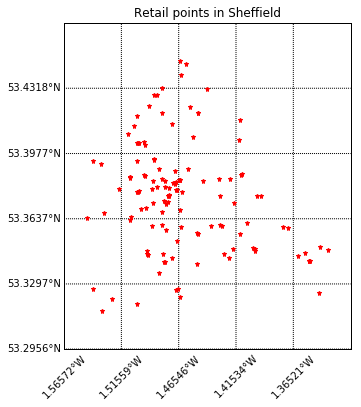

In [958]:
# map retail points in sheffield
# Extract the data we're interested in
lat = retail_points_shef['lat_wgs'].values
lon = retail_points_shef['long_wgs'].values

# How much to zoom from coordinates (in degrees)
zoom_scale = 0.02

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lat)-zoom_scale,np.max(lat)+zoom_scale,\
        np.min(lon)-zoom_scale,np.max(lon)+zoom_scale]

plt.figure(figsize=(12,6))

# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='h')

m.drawcoastlines()

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary()

# build and plot coordinates onto map
x,y = m(lon,lat)
m.plot(x,y,'r*',markersize=5)
plt.title("Retail points in Sheffield")
plt.show()

### Data Linkage
<hr>
It is now time to obtain data regarding the demand side of the analysis. The information we need to obtain is: 
* How many demand zones are there and what are their locations? 
* What are the available expenditure of the demand zones? 

In [959]:
# read postcode data

# This data will be used to assign postcodes to wardcodes. 
postcodes = pd.read_csv('postcodes.csv')

In [960]:
# make a copy of the dataset 
pcodes = postcodes
# select variables of interest (postcode and wardcode)
pcodes = pcodes.iloc[:,[2,6]]
# rename columns
pcodes = pcodes.rename(index=str, columns={"pcds": "postcode", "wd11cd": "ward_code"})
pcodes.head()

,postcode,ward_code
0,AL1 1AG,E05004802
1,AL1 1AJ,E05004802
2,AL1 1AR,E05004789
3,AL1 1AS,E05004799
4,AL1 1BH,E05004802


In [961]:
# read sheffield postcode data 
sheffield_codes = pd.read_csv('./Sheffield_postcodes.csv')

In [962]:
# keep only postcodes that are still in use. 
sheffield_codes = sheffield_codes.loc[sheffield_codes['In Use?']=='Yes',:]
# keep only columns that we need 
sheffield_codes = sheffield_codes.iloc[:,[0,4,5]]
# rename dataset columns
sheffield_codes = sheffield_codes.rename(index=str, columns={"Postcode": "postcode", "Easting": "easting",
                                                            'Northing':'northing'})

In [963]:
# merge sheffield postcodes with ward dataset to get all wards in the city of sheffield 
sheffield_codes = pd.merge(sheffield_codes, pcodes, on='postcode', how='inner')
# keep useful columns 
sheffield_codes = sheffield_codes.iloc[:, [3,1,2]]
# more that one postcode is assigned to the same ward. group data by ward and take the mean of the
# location to get a location coordinate for the ward.
sheffield_codes = sheffield_codes.groupby('ward_code').mean().reset_index()
sheffield_codes.head(2)

,ward_code,easting,northing
0,E05001020,441185.00000,389923.00000
1,E05001039,437160.90379,384844.64723


In [964]:
print('There are ', str(sheffield_codes.shape[0]), ' demand zones in ', city)

There are  30  demand zones in  Sheffield


In [965]:
# Read population data 
# this gives data about the economically active population in the demand zone. 
pop = pd.read_csv('./unemploy.csv')

In [966]:
population = pop
population = population.iloc[:, [1,5]]
population = population.iloc[1:]
population = population.rename(index=str, columns={"GEO_CODE": "ward_code", 
                                     "F244": "economically active"})
population.head()

,ward_code,economically active
1,95AA01,2473
2,95AA02,892
3,95AA03,840
4,95AA04,1660
5,95AA05,1362


### Create a "Demand" Dataset
At this point I need to generate data regarding the demand zones. Through the census data I was able to know how many people are economically active in each ward. An economically active individual is either employed or is looking for employment. 

I am assuming that each economically active individual of each ward will spend at least 10 pounds in supermarkets each week. After generating this assumption I can calculate the expenditure of each demand zone, and the total expenditure that the model will allocate to the supermarkets. 

In [967]:
# merge sheffield wardcodes with population data to get information about population in each ward.
demand = pd.merge(sheffield_codes, population, on='ward_code', how='inner')
# convert population column to float 
demand['economically active'] = demand['economically active'].astype(float)

# I am assuming that each economically active individual in the deman zone will spend 10 pounds per week on food. 
demand['expenditure'] = demand['economically active']*10
demand = demand.iloc[:,[0,1,2,4]]
demand = demand.set_index('ward_code')
demand.head()

,easting,northing,expenditure
ward_code,,,
E05001020,441185.000000,389923.000000,62920.0
E05001039,437160.903790,384844.647230,89230.0
E05001040,434464.363344,381142.086817,87710.0
E05001041,443061.252308,383108.584615,98910.0
E05001042,439911.310954,383325.293286,83920.0


In [968]:
print('The total expenditure is ', str(demand['expenditure'].sum()), ' per week')

The total expenditure is  2782600.0  per week


### Create a "Supply" Dataset 

The supply data needs to have information about the location and size of the retailer. It would be ideal to have exact information about the size of the retail point, however, the Geolytics data only gives a range of values. For example, store X is smaller than 280 sqm, or between 280 and 1400. To solve this problem, I decided to generate a random integer withing those bounds and to assume that to be the store size.  

In [969]:
# merge retail points data with postcode data to attach ward code to each store. 
supply = pd.merge(retail_points_shef, pcodes, on='postcode', how='inner')

In [970]:
# keep only useful columns 
supply_d = supply.iloc[:,[0,1,5,6,7]]
# rename columns 
supply_d = supply_d.rename(index=str, columns={"id": "id", "retailer": "retailer",
                                            'bng_e':'easting',
                                            'bng_n': 'northing',
                                            'size_sqm':'size'})

In [971]:
# what are the ranges of sizes we have? 
supply_d['size'].unique()

array(['Between 280 and 1,400', 'Over 2,800', 'Between 1,400 and 2,800',
       'Less than 280'], dtype=object)

In [972]:
# generate randon store sizes within the bounds of the ranges given. 
def size(row):
    #assing all rows to unspecified 
    value = 0
    # but, if  
    if row['size'] == 'Between 280 and 1,400':
        # give value 
        value = randint(280, 1400)
    if row['size'] == 'Over 2,800': 
        value = randint(2800, 3500)
    if row['size'] == 'Between 1,400 and 2,800':
        value = randint(1400, 2800)
    if row['size'] == 'Less than 280':
        value = randint(100,280)
    #at the end, return value
    return value

# apply function
supply_d['size'] = supply_d.apply(size, axis=1)

In [973]:
supply_d = supply_d.set_index('id')
supply_d.head()

,retailer,easting,northing,size
id,,,,
1010000414,Aldi,435703.41,394469.17,564
1010000423,Aldi,433918.19,383226.01,1114
1010001067,Asda,438184.00,384928.50,376
1010001068,Asda,435749.93,385867.44,554
1010001070,Asda,433051.56,390683.61,475


Now that the supply dataset is complete, let's look at how many retail points each retailer has in Sheffield. 

The graph below shows that the retailer witht he highest number of retail points in **The Co-operative Group** with 25 stores withing the modelled area. 

In [995]:
# bar graph showing which supermarkets have more retail points. 
d = supply.groupby('retailer', as_index=False).count()
d = d.sort_values(by=['id'], ascending = False)
plotly.tools.set_credentials_file(username='giacopini', api_key='sAkPM0WuDb2Ah30ixDFx')

trace0 = go.Bar(
    x= d['retailer'],
    y= d['id'],
    marker=dict(
        color=['rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)']),
)



data = [trace0]
layout = go.Layout(
    title='Retail Points by Retailer',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='text-hover-bar')

### Spatial Interaction Modelling

To recap, the expected flow of money between a demand zone and a destination is calculated by
$$S_{ij} = A_iO_iW_j exp(-\beta C_{ij})$$

Where, 

* $S_{ij}$ = flow of expected revenue of the supermarket

* $A_i$ = balancing factor that takes into account competition and ensures that demand is allocated to stores within the modelled region. it is calculated as: 

$$ A_i = \frac{1}{\sum W_j exp (-\beta C_{ij})}$$
 
* $W_j$ = represents the overall attractiveness of store j. In this case size is used as a proxy of attractiveness. 
* $exp(-\beta C_{ij})$ = represents the distance deterrence term. $\beta$ is between 0 and 1. $\beta$ = 0 means that the consumer does not mind travelling. $\beta$ = 1 means that the consumer does not want to travel. $C_ij$ represents the distance between demand zone and supermarket. 

I will complete this analysis in 5 easy steps


### 1. Calculate distance matrix $C_{ij}$
This matrix contains the distance from demand zones to supermarkets. In this case we will calculate the euclidean distance. 

$${\displaystyle d(\mathbf {p} ,\mathbf {q} )={\sqrt {(q_{1}-p_{1})^{2}+(q_{2}-p_{2})^{2}}}.}$$

In [975]:
# get coordinates od demand
coords_demand = demand.iloc[:,[0,1]]
# create a column of dataset where both coordinate are in a tuple
coords_demand['coords'] = coords_demand[['easting', 'northing']].apply(tuple, axis=1)
# discard columns where coordinates where separated. 
coords_demand = coords_demand.iloc[:,2]

In [976]:
# the same process is done for the supply dataset
coords_supply = supply_d.iloc[:,[1,2]]
coords_supply['coords'] = coords_supply[['easting', 'northing']].apply(tuple, axis=1)
coords_supply = coords_supply.iloc[:,2]

In [977]:
# calculate euclidean distance and append to list
distances = []
for j in range(demand.shape[0]):
    dist = []
    for i in range(supply.shape[0]):
        d = geopy.distance.vincenty(coords_demand.iloc[j],coords_supply.iloc[i]).km
        dist.append(d)
    distances.append(dist)  

In [978]:
# distance [] is now a list of lists. I want to make it a dataframe to then convert it to matrix
df = pd.DataFrame(distances)
df = df.transpose()
# convert to matrix 
Cij = df.as_matrix()
# this is the matrix of distances. 
Cij

array([[11579.27108757,  3860.08601596,  2354.13545013, ...,
        15058.76513885, 14423.12474376, 10801.25890367],
       [13002.83972318,  6594.27706577,  4201.59370656, ...,
        12198.04459469, 11134.06820425,  8623.7485972 ],
       [ 7485.44912617, 15358.11609151, 19007.36529306, ...,
         3920.74525381,  5248.2822813 ,  9967.13700189],
       ...,
       [ 9891.47674492,  3270.82567274,  4617.65623753, ...,
        13228.72711313, 13533.67819989, 12072.78118189],
       [ 7012.16926539, 14166.74766633, 17899.46487534, ...,
         1808.7926919 ,  4282.09260944, 10353.35099072],
       [ 5277.39209246, 12923.88767578, 17655.99278047, ...,
         6011.22017955,  7895.39624805, 12433.00585932]])

### 2. Get $W_j$

$W_j$ is the attractiveness of each retail point. In this project we are assuming that the attractiveness of a store is given by its size.

In [979]:
Wj = np.array(supply_d.iloc[:,3])
Wj

array([ 564, 1114,  376,  554,  475,  478,  640, 1129, 1117, 2859, 2410,
       3322,  245,  184,  621,  213,  120,  277,  171,  143,  114,  182,
        228,  225,  118,  167,  107,  137,  238,  209,  213,  256,  811,
        207,  821,  907,  867,  216,  280,  267,  267,  169,  279,  141,
        167,  816,  296,  170,  684,  184,  519,  267,  157,  176,  278,
        519,  599, 1126,  202,  611, 1198, 1098,  339,  692,  671,  493,
        116,  151,  403,  141,  957,  127,  738,  773])

### 3. Get $O_i$

$O_i$ is the expenditure available to consumers. 

In [980]:
Oi = np.array(demand.iloc[:,2])
Oi

array([ 62920.,  89230.,  87710.,  98910.,  83920.,  79470., 104930.,
       171180.,  91600.,  98530.,  81090.,  96990.,  97170.,  86730.,
        80690., 109310.,  93370., 104160.,  97100.,  93620., 108050.,
        89900., 100280.,  89000.,  94300.,  94040., 104530.,  91290.,
        85290.,  17290.])

### 4. Calculate $A_i$

$A_i$ is given by: 

$$ A_i = \frac{1}{\sum W_j exp (-\beta C_{ij})}$$

I am choosing a values of $\beta$ = 0.1
 

In [981]:
beta = 0.001
# take exp of distance matrix and mulptiply by negative beta
exp = np.exp(-beta*Cij)
# multiply exponential by w
w = exp.T * Wj
# sum across
s = w.sum(axis=1)
# take inverse of sum 
Ai = 1/s
Ai

array([0.00453988, 0.00116031, 0.00347252, 0.00056773, 0.00643182,
       0.00042309, 0.00242608, 0.00048883, 0.00109226, 0.00790952,
       0.00606139, 0.00469699, 0.00124282, 0.00455464, 0.00698599,
       0.00043149, 0.00349689, 0.00148882, 0.00865989, 0.00459416,
       0.01388143, 0.00053801, 0.00546915, 0.00176784, 0.00568889,
       0.00689344, 0.00076225, 0.00292   , 0.00877174, 0.00597103])

### 5. Calculate flow of money $S_{ij}$

In [982]:
Sij = w.T*(Ai*Oi)
Sij = Sij.sum(axis=1)

In [983]:
supply['expected revenue'] = Sij

In [984]:
supply.head()

,id,retailer,postcode,long_wgs,lat_wgs,bng_e,bng_n,size_sqm,ward_code,expected revenue
0,1010000414,Aldi,S35 9WN,-1.463917,53.445787,435703.41,394469.17,"Between 280 and 1,400",E05001049,57640.371280
1,1010000423,Aldi,S8 0JX,-1.491998,53.344848,433918.19,383226.01,"Between 280 and 1,400",E05001054,43311.984362
2,1010001067,Asda,S12 2AB,-1.427722,53.359861,438184.00,384928.50,"Between 280 and 1,400",E05001039,30038.787629
3,1010001068,Asda,S2 4DR,-1.464188,53.368470,435749.93,385867.44,"Between 280 and 1,400",E05001045,80683.218132
4,1010001070,Asda,S6 1TA,-1.504237,53.411934,433051.56,390683.61,"Between 280 and 1,400",E05001055,21700.866842


In [985]:
# has all money been allocated? 
total_revenue = Sij.sum()
total_demand = Oi.sum()

print('the total revenue is ', total_revenue, ' the total money household have to spend on food is ', total_demand )

the total revenue is  2782600.0  the total money household have to spend on food is  2782600.0


## Findings

In [986]:
# bar graph to show which retailer is expected the higher weekly revenue
total_revs = supply.groupby('retailer', as_index=False).sum()
# sort from higher expected revenue to lower
total_revs = total_revs.sort_values(by=['expected revenue'], ascending = False)

In [992]:
trace0 = go.Bar(
    x= total_revs['retailer'],
    y= total_revs['expected revenue'],
    marker=dict(
        color=['rgba(222,45,38,0.8)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)','rgba(204,204,204,1)',
               'rgba(204,204,204,1)']),
)

data = [trace0]
layout = go.Layout(
    title='Retailer Weekly Expected Revenue',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='color-bar')

We can see that **The Co-operatvie Group** is the retailer that can expect the highest weekly revenue. This can be due to the fact that they have 25 retail points in Sheffield. The picture below shows that The Co-operative Group can expect to receive the 24.2% of the expenditure available in the modelled area (Sheffield).

It is also important to point out how **Morrisons**, with just 2 stores in the city was able to attract 12% of total demand. This is possibly due to the fact that the retailer has attractive stores in attractive locations. 

In [988]:
# pie chart
labels = total_revs['retailer']
values = total_revs['expected revenue']

trace = go.Pie(labels=labels, values=values)

py.iplot([trace], filename='basic_pie_chart')


### Conclusion
<hr>
This project is an attempt at using spatial interaction modelling to predict revenue of Sheffield supermarkets. This model can be improved with information regarding store sizes, actual available expenditure, actual data regarding deman zones. 

Thank you to the CDRC and the lecturers for introducting me to SIM, a technique I will definitely take into account when working on my own retailing research. 